In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re

import konlpy
from nltk import download
import nltk
from nltk.tokenize import RegexpTokenizer

from PIL import Image
from wordcloud import WordCloud
from collections import Counter

In [2]:
df = pd.read_excel('./원본데이터/0105_0112.xlsx')
df

,내용
0,최신 헨리여권지수에 따르면 일본이 193개국에 무비자 입국을 허용하면서 세계에서 가...
1,"팝 음악에서 수상에 빛나는 드라마와 영화(기생충, 오징어 게임 등)에 이르기까지, ..."
2,"꿈꾸는 밤 외출이 그릴에서 갓 구워낸 고기와 김치 반찬, 노래방인가?\n \n 코리..."
3,오스카상 후보에 올랐던 고레에다 히로카즈 감독의 2018년작 <어느 가족>은 거짓말...
4,세계의 많은 사람들이 방탄소년단과 블랙핑크와 같은 슈퍼스타의 팝 음악 퍼포먼스를 통...
...,...
96,코로나19 여파로 2년여간 중단됐던 얼음낚시축제가 올해 화천에서 열린다. 23일간 ...
97,한국 남자 하키 주장 이남용은 팀이 경험이 많고 2023 부바네스와르-루르켈라 FI...
98,한국의 김톰(김주형)은 1라운드 65타에 4언더파 69타를 추가해 12언더파가 됐고...
99,대립되는 요소들의 조화로 구성된 나라인 한국은 우리를 놀라게 한다. 한국의 다이내믹...


### 한국어

In [3]:
kor_stopwords = ['한국','문화','우리','가장','사람','위해','대한','이번','다른','자신','문화원','시간','모든','대해','통해','지난','동안','매우','올해','다음','때문','하나','생각',
                '또한','이후','강전','지금','현재','그녀','계속','여성','이상','목록','기자','가지','처음','모두','산업','준비','지역','차지','최근','모습']
kor_total = []

Okt = konlpy.tag.Okt()

In [4]:
for news in df['내용']:
    news = news.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','')
    pos_news = [''.join(t[:-1]) for t in Okt.pos(news) if ((t[1] == 'Noun') & (t[0] not in kor_stopwords))]
    kor_total.append(' '.join(pos_news))

In [5]:
#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
kor_vectorizer = TfidfVectorizer()
kor_tfidf = kor_vectorizer.fit_transform(kor_total)

In [6]:
kor_tfidf_weights = [(word, kor_tfidf.getcol(idx).sum()) for word, idx in kor_vectorizer.vocabulary_.items()]
kor_tfidf_weights[0:10]

[('최신', 0.5469725655856843),
 ('헨리', 0.3227796810699804),
 ('여권', 0.6897026635178988),
 ('지수', 1.1972594488622417),
 ('일본', 2.4441678873906314),
 ('개국', 0.4456209507556207),
 ('무비', 0.43543402975222784),
 ('입국', 0.3631480749090567),
 ('허용', 0.10207446697605316),
 ('세계', 2.253954171892871)]

### 영어

In [40]:
eng_stopwords = ['The', 'the', 'korean', 'Korean','korea','Korea','kore','Kore','top','TOP']
eng_total = []

# 3글자 이상
tokenizer = RegexpTokenizer("[\w']{3,}")

In [41]:
for news in df['내용']:
    temp = []
    news = news.replace('.', '').replace(',','').replace("'","").replace('·', ' ').replace('=','')
    news = re.sub('[^a-zA-Z ]', '', news).strip()
    pos_news = [t for t in tokenizer.tokenize(news)]
    for i in range(len(pos_news)):
        if pos_news[i] not in eng_stopwords:
            temp.append(''.join(pos_news[i]))
    eng_total.append(' '.join(temp))

In [42]:
# TfidfVectorizer
eng_vectorizer = TfidfVectorizer()
eng_tfidf = eng_vectorizer.fit_transform(eng_total)

In [43]:
eng_tfidf_weights = [(word, eng_tfidf.getcol(idx).sum()) for word, idx in eng_vectorizer.vocabulary_.items()]
eng_tfidf_weights[0:10]

[('iata', 1.0039046161967253),
 ('jnto', 0.7367432290000959),
 ('barbecue', 0.3036957164685032),
 ('girls', 0.41697045775568875),
 ('instagrammable', 0.3036957164685032),
 ('radish', 0.3036957164685032),
 ('salad', 0.3036957164685032),
 ('hibachi', 0.3036957164685032),
 ('handheld', 0.3036957164685032),
 ('wrapper', 0.3036957164685032)]

### 한국어 + 영어 데이터프레임으로 합치기

In [44]:
kor_df = pd.DataFrame(kor_tfidf_weights, columns = ['word', 'tfidf'])
eng_df = pd.DataFrame(eng_tfidf_weights, columns = ['word', 'tfidf'])

In [45]:
final = pd.concat([kor_df, eng_df], axis=0)
final = final.sort_values('tfidf', ascending=False)
final = final.reset_index(drop=True)
final

,word,tfidf
0,영화,3.483409
1,감독,3.272153
2,bts,3.014364
3,선수,2.953218
4,축제,2.942397
...,...,...
5251,모국,0.015292
5252,부합,0.015292
5253,차세대,0.015292
5254,고국,0.015292


### 블랙 - 핑크

In [46]:
#final.loc[final['word'] == '블랙', 'word'] = '블랙핑크'
#final = final.drop(index=final.loc[final.word == '핑크'].index)
#final.reset_index(drop=True, inplace=True)

### 영어 대문자로

In [47]:
final.loc[final['word'] == 'bts', 'word'] = 'BTS'
final.loc[final['word'] == 'kpop', 'word'] = 'Kpop'
final.loc[final['word'] == 'fifa', 'word'] = 'FIFA'

In [48]:
final = final.head(100)
final_dict = final.set_index('word').to_dict()['tfidf']
final_dict

{'영화': 3.4834087189212606,
 '감독': 3.2721530323918957,
 'BTS': 3.0143644070389186,
 '선수': 2.9532175066604753,
 '축제': 2.942396896801138,
 '넷플릭스': 2.697129012648233,
 '드라마': 2.6942010142239368,
 '일본': 2.4441678873906314,
 '세계': 2.253954171892871,
 '방탄소년단': 2.0939339063899616,
 '필리핀': 2.007184156553504,
 '콘텐츠': 2.0050070964308246,
 'kbs': 2.0,
 'itf': 2.0,
 '핑크': 1.9990853511867475,
 '작품': 1.9531154642853639,
 '블랙': 1.835851609039705,
 '음식': 1.773871714031,
 'Kpop': 1.6934782983403065,
 '이야기': 1.6217353103293768,
 '시작': 1.618618092288155,
 '인기': 1.5987204455861124,
 '그룹': 1.5846345583085337,
 '서울': 1.5779210617590693,
 '한류': 1.5744253315144419,
 'nct': 1.5547773474026991,
 'university': 1.5211557017625128,
 '얼음': 1.4833571897715412,
 '산천어': 1.4487649907726121,
 '북한': 1.402574874105089,
 '방문': 1.3935079571427937,
 '공연': 1.3820990279075434,
 '행사': 1.3719311913956262,
 '국가': 1.3707762193565143,
 '활동': 1.364660474173856,
 '요리': 1.364651328889516,
 '박찬욱': 1.3634297888253413,
 'ildefonso': 1.357

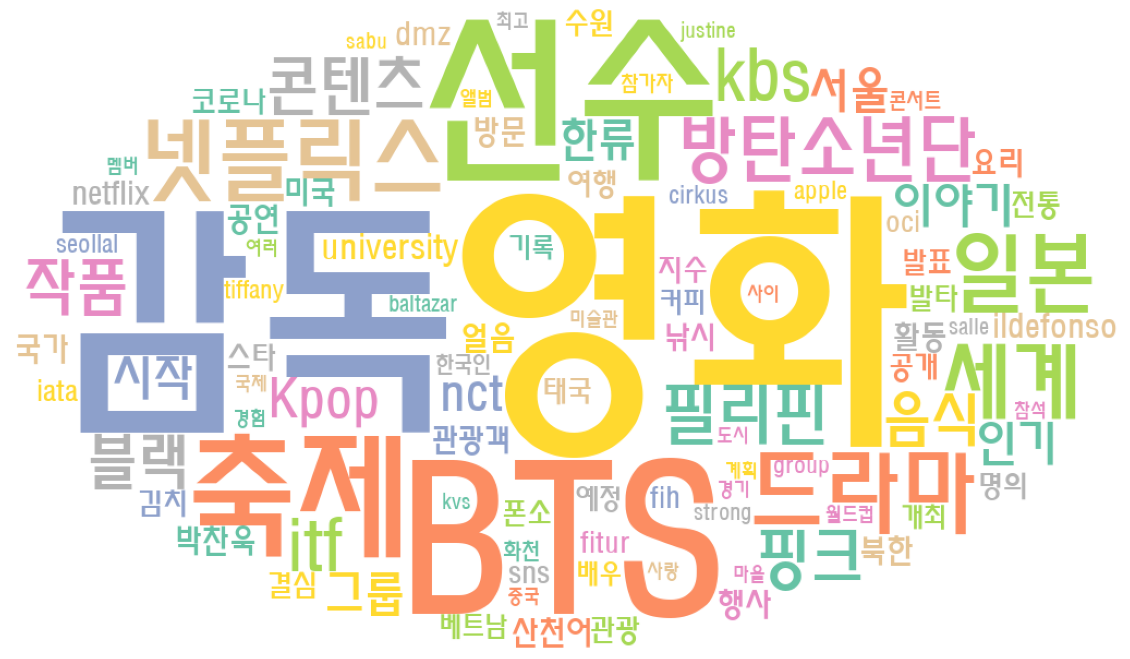

In [49]:
im = Image.open('mask.png') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

sns.set_style('white')
font_path = 'C:\Windows\Fonts\HMFMMUEX.TTC'

#prefer_horizontal=Ture -> 글씨 똑바르게 나오게 하기
wc = WordCloud(font_path=font_path, width=1500, height=1200, background_color='white', colormap='Set2', mask=mask_arr, prefer_horizontal=True).fit_words(final_dict)

plt.figure(figsize = (20, 20))  
plt.imshow(wc)
plt.axis('off')
plt.show()